<table border=0px>
<tr>
<td>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/5a/HuffPost.svg/320px-HuffPost.svg.png">
</td>
<td>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/09/Flag_of_South_Korea.svg/320px-Flag_of_South_Korea.svg.png">
</td>
</tr>
</table>

# Analyse des sources de l'édition sud-coréenne du *Huff Post* (2014-2016) en 6 étapes faciles
<hr>

<h3 style="background:teal;color:white;padding:5px">Étape 1 - Initialisation de notre *notebook* et lecture du fichier CSV contenant nos données</h3>

In [1]:
import csv, re, random
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats, integrate
pd.set_option('display.max_colwidth', -1)
pd.options.display.max_rows = 25
pd.options.mode.chained_assignment = None
%matplotlib inline

On lit notre fichier CSV de base, puis on crée une variable `edition` pour identifier le pays sur lequel on va travailler. La variable `huff` ne contient que les articles de l'édition du pays auquel on s'intéresse ici.

In [2]:
huff = pd.read_csv("scraping-nettoye.csv", low_memory=False)
edition = "Corée du Sud"
huff = huff[huff.pays == edition]
huff.shape

(53406, 13)

Le but de cet exercice étant d'identifier le taux d'originalité du *HuffPost*, on va créer trois variables.

- `HP_oui` contiendra la proportion d'articles qui sont originaux (signés par des employés du *HuffPost* ou des pigistes).
- `HP_non` contiendra la proportion d'articles qui ne sont pas originaux (repris d'agences externes ou d'autres médias).
- `HP_inconnu` contiendra la proportion d'articles dont on ne peut pas établir la provenance.

La somme de ces trois variables équivaudra à 100. On s'en servira pour faire un graphique en pointes de tarte (camembert) à la fin.

In [3]:
HP_oui = 0
HP_non = 0
HP_inconnu = 0

<h3 style="background:teal;color:white;padding:5px">Étape 2 - Filtrer les balises <i>meta</i></h3>

<hr>
Ce ne sont pas tous les articles de cette édition du *Huff Post* qui ont, pour nom dans leurs balises `meta`, l'une ou l'autre des éditions du *Huffington Post*, ou de sa compagnie-mère, AOL

In [4]:
huff.meta.value_counts()

HuffPost               53323
The Huffington Post    53   
Le Huffington Post     11   
중앙일보                   9    
SBS NEWS               4    
KBS 뉴스                 3    
ìì¬IN               1    
ㅍㅍㅅㅅ                   1    
ë¯¸ëì´ì¤ë        1    
Name: meta, dtype: int64

Créons un sous-ensemble avec les articles qui, selon la balise `meta`, semblent issus du *HP*.

In [5]:
metaHP = huff.meta.str.contains("[H,Η,h][U,u][F,f][i,F,f,P,p]|ハフ|ポスト|허핑턴|허프|[A,a][O,o][L,l]", na=False)
huff[metaHP].meta.value_counts()

HuffPost               53323
The Huffington Post    53   
Le Huffington Post     11   
Name: meta, dtype: int64

In [6]:
huff[metaHP].shape

(53387, 13)

In [7]:
len(huff) - len(huff[metaHP])

19

Le calcul ci-haut nous indique qu'on a **19 articles** qu'on peut d'ores et déjà ranger dans la catégorie des articles qui ne sont *pas* rédigés par l'équipe du *HuffPost*.
<hr>
Examinons cependant de plus près notre sous-ensemble d'articles dont la balise `meta` prétend qu'ils sont issus du *HuffPost* en regardant qui sont les signataires de ces articles. Les signataires se trouvent dans la colonne `byline`. Voyons voir, donc, ce qu'elle contient.

<h3 style="background:teal;color:white;padding:5px">Étape 3 - Identification des articles dont les signataires sont inconnus</h3>

In [8]:
huff[metaHP].byline.value_counts()

? 연합뉴스                                 8374
작성자강병진 HuffPost                        3220
작성자박세회 HuffPost                        2556
? HuffPost                             2363
작성자허완 HuffPost                         1774
작성자 곽상아 HuffPost                       1494
작성자원성윤 HuffPost                        1436
작성자김도훈 HuffPost                        1228
작성자박수진 HuffPost                        1122
작성자김태우 HuffPost                        1120
작성자김현유 HuffPost                        643 
작성자권복기 HuffPost                        629 
                                      ...  
작성자 김상훈 강원대 교수 한겨레                     1   
작성자 케임브리지<미국 매사추세츠주>=이강원 특파원 연합뉴스      1   
작성자 Naina Chaturvedi HuffPost India    1   
작성자 연합뉴스 = 김종우 특파원(로스앤젤레스) 연합뉴스        1   
작성자 이정연 한겨레21                          1   
? 금강산=연합뉴스                             1   
작성자 박수진 김효실 김선식 기자 한겨레21               1   
작성자 이유주현 하어영 기자 한겨레                    1   
작성자 황준범 이정애 기자 한겨레                     1   
작성자 泉谷由梨子 The Huffington Post   

Un certain nombre d'auteurs sont inconnus («&nbsp;?&nbsp;» ou «&nbsp;?&nbsp;?&nbsp;»).<br>
Ceux marqués d'un seul point d'interrogation seront placés dans le sous-ensemble `inconnu1`, ceux qui sont marqués de deux points d'interrogation dans le sous-ensemble `inconnu2`.<br>
Ils représentent moins de **1%** du total des articles de cette édition du *Huffington&nbsp;Post*.<br>
Nous allons placer cette proportion dans notre variable `HP_inconnu`.

In [9]:
inconnus1 = huff[metaHP].byline == "? "
inconnus2 = huff[metaHP].byline == "? ?"
HP_inconnu = huff[metaHP][inconnus1].pays.count() + huff[metaHP][inconnus2].pays.count()
HP_inconnu, (HP_inconnu/len(huff))*100

(469, 0.87817848181852221)

<hr>
<h3 style="background:teal;color:white;padding:5px">Étape 4 - Identification des articles originaux au <i>HuffPost</i></h3>

Examinons maintenant les articles dont la signature contient certaines chaînes de caractères qui correspondent au *Huffington Post* (dans différentes langues, fautes de frappe incluses), ou à sa compagnie-mère, AOL. On va baptiser ce sous-ensemble `signéHP`.

In [10]:
signeHP = huff[metaHP].byline.str.contains("[H,h][U,u,f][F,f][i,F,f,P,p]|ハフ|ポスト|허핑턴|허프|[A,a][O,o][L,l]",na=False)
huff[metaHP][signeHP].shape

(27442, 13)

In [11]:
huff[metaHP][signeHP].byline.value_counts(), huff[metaHP][signeHP].byline.value_counts().count()

(작성자강병진 HuffPost                                                                   3220
 작성자박세회 HuffPost                                                                   2556
 ? HuffPost                                                                        2363
 작성자허완 HuffPost                                                                    1774
 작성자 곽상아 HuffPost                                                                  1494
 작성자원성윤 HuffPost                                                                   1436
 작성자김도훈 HuffPost                                                                   1228
 작성자박수진 HuffPost                                                                   1122
 작성자김태우 HuffPost                                                                   1120
 작성자김현유 HuffPost                                                                   643 
 작성자권복기 HuffPost                                                                   629 
 작성자남현지 HuffPost                

Le *Huffington Post* est nommé, d'une façon ou d'une autre, dans ces quelque **27&nbsp;442 articles** signés par **1&nbsp;568 signataires différents**.<br>
Cela représente un peu plus de la moitié de l'ensemble des articles publiés par cette édition du *HuffPost* dans la période étudiée.
On peut placer cette proportion dans notre variable `HP_oui`.

In [12]:
HP_oui = huff[metaHP][signeHP].pays.count()
HP_oui, (HP_oui/len(huff))*100

(27442, 51.383739654720436)

<hr>
<h3 style="background:teal;color:white;padding:5px">Étape 5 - Identification des articles <u>extérieurs</u> au <i>HuffPost</i></h3>

On va donc faire la même opération, mais pour tous les postes dans lesquels **on ne trouve pas** les chaînes de caractères permettant d'identifier le *Huffington&nbsp;Post* dans différentes langues. On va créer un nouveau sous-ensemble qu'on va baptiser `NONsignéHP`.

In [13]:
NONsigneHP = ~huff[metaHP].byline.str.contains("[H,h][U,u,f][F,f][i,F,f,P,p]|ハフ|ポスト|허핑턴|허프|[A,a][O,o][L,l]",na=False)
huff[metaHP][NONsigneHP].shape

(25945, 13)

Qui sont ces auteurs qui ne signent pas des articles originaux pour le *HuffPost*?

In [14]:
huff[metaHP][NONsigneHP].byline.value_counts(), huff[metaHP][NONsigneHP].byline.value_counts().count() 

(? 연합뉴스                     8374
 ?                          388 
 ? 서울=연합뉴스                  268 
 작성자 표재민 기자 OSEN            240 
 작성자 최나영 기자 OSEN            232 
 작성자 선미경 기자 OSEN            180 
 작성자 김경주 기자 OSEN            179 
 ? 워싱턴=연합뉴스                 162 
 작성자 박현민 기자 OSEN            160 
 작성자 강서정 기자 OSEN            154 
 작성자 샌프란시스코=임화섭 특파원 연합뉴스    131 
 작성자 정준화 기자 OSEN            120 
                           ...  
 작성자 김지훈 임수정 기자 연합뉴스        1   
 작성자 이승우 송진원 기자 연합뉴스        1   
 작성자 도쿄 = 길윤형 특파원 한겨레       1   
 작성자 황준범 석진환 기자 한겨레         1   
 ? 방콕 AFP=연합뉴스              1   
 작성자 노형석기자 한겨레              1   
 작성자 문현숙 남지은 김외현 기자 한겨레     1   
 ? 수루치=AFP/연합뉴스             1   
 작성자 한지훈 기자/연합뉴스 연합뉴스       1   
 작성자 이정오 월간 웹               1   
 작성자 박태우 방준호 기자 한겨레         1   
 작성자 홍대선 노현웅 기자 한겨레         1   
 Name: byline, Length: 4144, dtype: int64, 4144)

On constate que l'édition sud-coréenne a recours à un grand nombre d'agences ou de sites extérieurs:

- **연합뉴스** est l'agence [Yonhap](http://www.yonhapnews.co.kr/).
- **OSEN** est un [site d'information](http://osen.mt.co.kr/).
- **한겨레** est un autre site d'information, [Hani](http://www.hani.co.kr/).

L'expression **작성자** qu'on retrouve dans presque toutes les signatures signifie «&nbsp;auteur&nbsp;».

Ensemble, ils représentent près de la moitié du contenu d'information de l'édition sud-coréenne du *HuffPost*. À ce nombre, on retranche les articles contenus dans les deux sous-ensembles `inconnu1` et `inconnu2`.

In [15]:
HP_non = huff[metaHP][NONsigneHP].pays.count() - (huff[metaHP][inconnus1].pays.count() + huff[metaHP][inconnus2].pays.count())
HP_non, (HP_non/len(huff))*100

(25476, 47.702505336479042)

On a désormais tout ce qu'il nous faut pour faire le camembert évoqué plus haut.

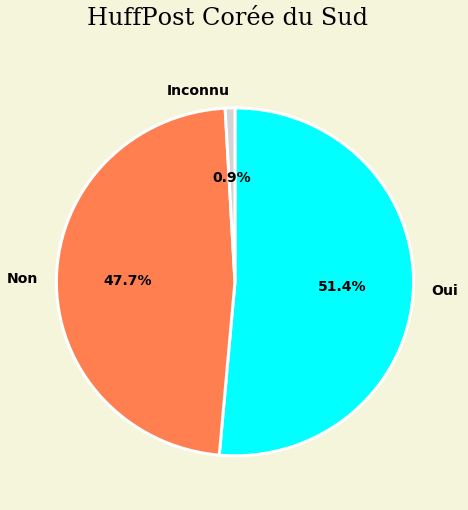

In [16]:
camembert = pd.Series([HP_oui,HP_non,HP_inconnu], index=["Oui","Non","Inconnu"],name="")
titre = plt.figure(facecolor="beige")
titre.suptitle("HuffPost Corée du Sud", fontsize=24, fontweight="light", fontname="Serif")
camembert.plot.pie(colors=["aqua","coral","lightgrey"],
                   wedgeprops={"linewidth":3,"edgecolor":"white"},
                   textprops={"weight":"bold","fontsize":14},
                   counterclock=False,
                   startangle=90,
                   autopct="%1.1f%%",
                   figsize=(8,8)
)

<hr>
<h3 style="background:teal;color:white;padding:5px">Étape 6 - Exercice boni&nbsp;: les étiquettes (<i>tags</i>)</h3>

Chaque article du *Huffington Post* est généralement accompagné d'une dizaine de marqueurs, ou d'étiquettes (*tags* en anglais). Voici ceux qui sont le plus fréquemment utilisés par cette édition.

In [17]:
etiquettes = huff.set_index('pays').tags.str.split(',', expand=True).stack().rename(columns={0:'tag'}).reset_index(drop=True)
etiquettes.value_counts(dropna=False)

국제              12779
사회              11260
문화              7417 
정치              5921 
라이프스타일          5037 
코미디             3033 
경제              2959 
동물              2641 
미국              2332 
영화              2270 
박근혜             2040 
스포츠             2015 
                ...  
덴마크 여행          1    
Top Knot        1    
반기문 대통령         1    
음악 스트리밍         1    
아메리칸 어패럴 선정성    1    
일본 상임이사국        1    
도전슈퍼모델          1    
예수 그림           1    
중앙대 박용성         1    
5.16 쿠데타        1    
사전녹화            1    
솔비티저            1    
Length: 102016, dtype: int64